# **Skenario 1 - CNN VGG16**

Skenario 1 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur VGG16 untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Import beberapa pustaka seperti `NumPy`, `Pandas`, `Seaborn`, `Matplotlib`, dan `Scikit-learn` untuk analisis data, serta menggunakan `TensorFlow` dan `Keras` untuk mengimplementasikan model deep learning.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Scikit-learn 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# TensorFlow and Keras imports
import tensorflow as tf
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data

Load data dari image_selected.npz 

In [2]:
def load_and_preprocess_data(preprocess_images=True):
    # Direktori tempat file NPZ disimpan
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Muat data dari file NPZ
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Daftar untuk data input (X) dan output (Y)
    X = []
    Y = []

    # Buat pemetaan label u/ tiap kelas
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterasi melalui data yang diload
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, original_slice = selected_slice

                if preprocess_images:
                    # Perluas dimensi dan ulangi untuk representasi RGB
                    original_slice = np.expand_dims(original_slice, axis=-1)
                    original_slice = np.repeat(original_slice, 3, axis=-1)

                    # Penskalaan Min-Max untuk membawa nilai piksel ke dalam rentang [0, 1]
                    min_val = np.min(original_slice)
                    max_val = np.max(original_slice)
                    original_slice = (original_slice - min_val) / (max_val - min_val)

                X.append(original_slice)
                Y.append(label_mapping[label])

    # Konversi daftar menjadi array NumPy
    X = np.array(X) 
    Y = np.array(Y, dtype=int)  # Konversi label menjadi bilangan bulat

    return X, Y


In [3]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data(preprocess_images=True)

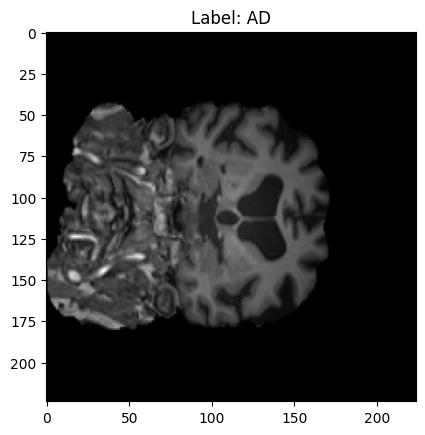

In [4]:
index_to_visualize = 0
image_to_visualize = X[index_to_visualize]
label_to_visualize = Y[index_to_visualize]

class_names = {0: 'AD', 1: 'CN', 2: 'EMCI', 3: 'LMCI'}
label_to_visualize = class_names[np.argmax(label_to_visualize)]

plt.imshow(image_to_visualize)
plt.title(f"Label: {label_to_visualize}")
plt.imshow(image_to_visualize, cmap='gray')

### 2.2 Pembagian Data
Data dibagi dengan rasio 80:20 

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cek shape dan jumlah data

In [6]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224, 3)
Dimensi Y_train: (5760,)
Dimensi X_test: (1440, 224, 224, 3)
Dimensi Y_test: (1440,)


## 3. Buat dan Konfigurasi Model
Arsitektur yang digunakan yaitu VGG16 sebagai bagian dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [7]:
def create_model():
    inputs = Input(shape=(224, 224, 3))
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  
    x = Dropout(0.5)(x) 
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = create_model()
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

mendefinisikan dua fungsi, specificity dan sensitivity

In [8]:
import keras.backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', specificity, sensitivity])

## 4. Training Model

Inisialisasi `StratifiedKFold` dengan 5 lipatan, dan mengatur callback `Early Stopping `dan `Model Checkpoint` untuk digunakan selama pelatihan model

In [9]:
n_splits = 5 
# Inisialisasi StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)  

# Tentukan callback Early Stopping dan Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(r'D:\Users\RESA\Coding\Model\M_VGG16.h5', monitor='val_loss', save_best_only=True)

Melatih dan mengevaluasi model pada setiap lipatan (fold) menggunakan `Stratified K-Fold cross-validation`, menyimpan metrik hasil evaluasi 

In [10]:
# List untuk menyimpan metrik dan riwayat model untuk setiap fold
accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_score_per_fold = []
roc_auc_per_fold = []
model_history_per_fold = []

for fold, (train_index, test_index) in enumerate(skf.split(X, Y)):
    print(f"Training on Fold: {fold+1}/{n_splits}...")

    # Split data menjadi data train dan test untuk setiap fold
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Buat model untuk setiap fold
    model = create_model()

    # Latih model dengan menggunakan Early Stopping dan Model Checkpoint callbacks
    history = model.fit(
        X_train, to_categorical(Y_train, num_classes=len(set(Y))),
        epochs=25, batch_size=32,
        validation_data=(X_test, to_categorical(Y_test, num_classes=len(set(Y)))),
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluasi model pada data test untuk setiap lipatan
    Y_test_pred = model.predict(X_test)
    Y_test_pred_classes = np.argmax(Y_test_pred, axis=1)

    # Hitung metrik
    accuracy_per_fold.append(accuracy_score(Y_test, Y_test_pred_classes))
    precision_per_fold.append(precision_score(Y_test, Y_test_pred_classes, average='weighted'))
    recall_per_fold.append(recall_score(Y_test, Y_test_pred_classes, average='weighted'))
    f1_score_per_fold.append(f1_score(Y_test, Y_test_pred_classes, average='weighted'))

    # Label biner menggunakan LabelBinarizer
    lb = LabelBinarizer()
    Y_test_binary = lb.fit_transform(Y_test)
    Y_test_pred_binary = lb.transform(Y_test_pred_classes)

    # Hitung ROC AUC untuk setiap kelas
    roc_auc_fold = []
    for i in range(len(lb.classes_)):
        fpr, tpr, _ = roc_curve(Y_test_binary[:, i], Y_test_pred_binary[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_fold.append(roc_auc)

    roc_auc_per_fold.append(roc_auc_fold)

    model_history_per_fold.append(history)

    # Cetak laporan klasifikasi untuk setiap lipatan
    classification_rep = classification_report(Y_test, Y_test_pred_classes)
    print(f"Laporan Klasifikasi untuk Lipatan {fold+1}:\n{classification_rep}")


Training on Fold: 1/5...


Epoch 1/25


180/180 [==============================] - ETA: 0s - loss: 3.6685 - accuracy: 0.3273

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 467s 3s/step - loss: 3.6685 - accuracy: 0.3273 - val_loss: 2.4415 - val_accuracy: 0.3590
Epoch 2/25
180/180 [==============================] - 465s 3s/step - loss: 2.1363 - accuracy: 0.4049 - val_loss: 1.9096 - val_accuracy: 0.4528
Epoch 3/25
180/180 [==============================] - 464s 3s/step - loss: 1.7860 - accuracy: 0.4486 - val_loss: 1.6642 - val_accuracy: 0.5361
Epoch 4/25
180/180 [==============================] - 466s 3s/step - loss: 1.6001 - accuracy: 0.4684 - val_loss: 1.5241 - val_accuracy: 0.5076
Epoch 5/25
180/180 [==============================] - 464s 3s/step - loss: 1.4712 - accuracy: 0.4960 - val_loss: 1.4135 - val_accuracy: 0.5271
Epoch 6/25
180/180 [==============================] - 464s 3s/step - loss: 1.3745 - accuracy: 0.5236 - val_loss: 1.3261 - val_accuracy: 0.5569
Epoch 7/25
180/180 [==============================] - 464s 3s/step - loss: 1.3187 - accuracy: 0.5361 - val_loss: 1.3037 - val_accuracy: 0.5722
Epoch 8/25

## 4. Testing

Test Data

In [11]:
evaluation_result = model.evaluate(X_test, to_categorical(Y_test, num_classes=4), verbose=1)

# Menampilkan hasil evaluasi
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

# Prediksi menggunakan data uji
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

print('Label Sebenarnya : ', Y_test)
print('Label Prediksi : ', predicted_labels)

45/45 [==============================] - 92s 2s/step - loss: 0.9719 - accuracy: 0.7201
Loss: 0.9718834161758423
Accuracy: 0.7201389074325562
45/45 [==============================] - 92s 2s/step
Label Sebenarnya :  [0 0 0 ... 3 3 3]
Label Prediksi :  [0 0 0 ... 3 3 2]


## 5. Evaluasi dan Visualisasi

Evaluasi model yang telah diuji

In [12]:
# Find the fold with the best validation loss
best_fold = np.argmin([history.history['val_loss'][-1] for history in model_history_per_fold])

# Retrieve the model with the best performance
best_model = create_model()
best_model.set_weights(model_history_per_fold[best_fold].model.get_weights())

# Evaluate the best model on the validation set
Y_test_pred_best = best_model.predict(X_test)
Y_test_pred_classes_best = np.argmax(Y_test_pred_best, axis=1)

45/45 [==============================] - 91s 2s/step


classification report

In [13]:
classification_rep_best = classification_report(Y_test, Y_test_pred_classes_best)
print(f"Best Model - Classification Report:\n{classification_rep_best}")

Best Model - Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       360
           1       0.92      0.83      0.87       360
           2       0.81      0.92      0.86       360
           3       0.91      0.83      0.87       360

    accuracy                           0.88      1440
   macro avg       0.88      0.88      0.88      1440
weighted avg       0.88      0.88      0.88      1440



confusion matrix

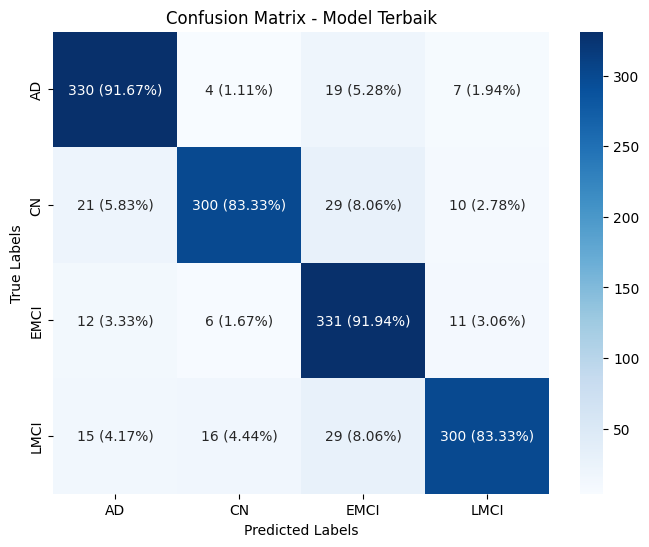

In [14]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

# Hitung confusion matrix u/ model terbaik
conf_matrix_best = confusion_matrix(Y_test, Y_test_pred_classes_best)

# Normalisasi confusion matrux untuk mendapatkan persentase
conf_matrix_percentage = conf_matrix_best.astype('float') / conf_matrix_best.sum(axis=1)[:, np.newaxis]

# Buat anotasi kustom
annotations = [['{} ({:.2%})'.format(value, percentage) for value, percentage in zip(row, row_percentage)]
               for row, row_percentage in zip(conf_matrix_best, conf_matrix_percentage)]

# Plot conf matrix dgn anotasi kustom
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=annotations, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Model Terbaik')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [15]:
# Jmlh kelas dalam data test
num_classes = len(set(Y_test))

# List untuk nyimpen sensitivitas dan spesifisitas /kelas
sensitivity = []
specificity = []

# Iterasi untuk tiap kelas
for i in range(num_classes):
    # True Positive (tp), False Negative (fn), False Positive (fp), True Negative (tn)
    tp = conf_matrix_best[i, i]
    fn = np.sum(conf_matrix_best[i, :]) - tp
    fp = np.sum(conf_matrix_best[:, i]) - tp
    tn = np.sum(conf_matrix_best) - tp - fn - fp

    # Hitung sensitivitas & spesifisitas
    sensitivity.append(tp / (tp + fn))
    specificity.append(tn / (tn + fp))

print("Sensitivitas per kelas:", sensitivity)
print("Spesifisitas per kelas:", specificity)

Sensitivitas per kelas: [0.9166666666666666, 0.8333333333333334, 0.9194444444444444, 0.8333333333333334]
Spesifisitas per kelas: [0.9555555555555556, 0.975925925925926, 0.9287037037037037, 0.9740740740740741]


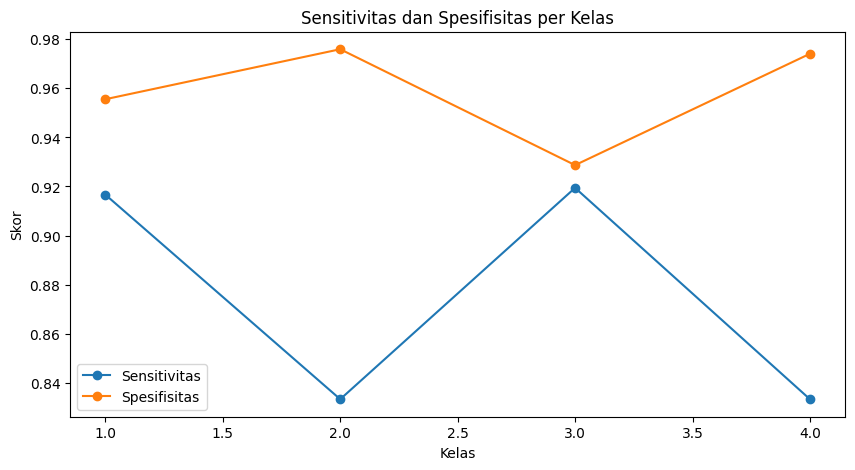

In [16]:
# Jmlh kelas yg digunakan
num_classes = len(sensitivity)

# Plotting sensitivitas dan spesifisitas pd grafik yang sama
plt.figure(figsize=(10, 5))

# Plot sensitivitas
plt.plot(range(1, num_classes + 1), sensitivity, marker='o', linestyle='-', label='Sensitivitas')

# Plot spesifisitas
plt.plot(range(1, num_classes + 1), specificity, marker='o', linestyle='-', label='Spesifisitas')

plt.title('Sensitivitas dan Spesifisitas per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Skor')
plt.legend()
plt.show()

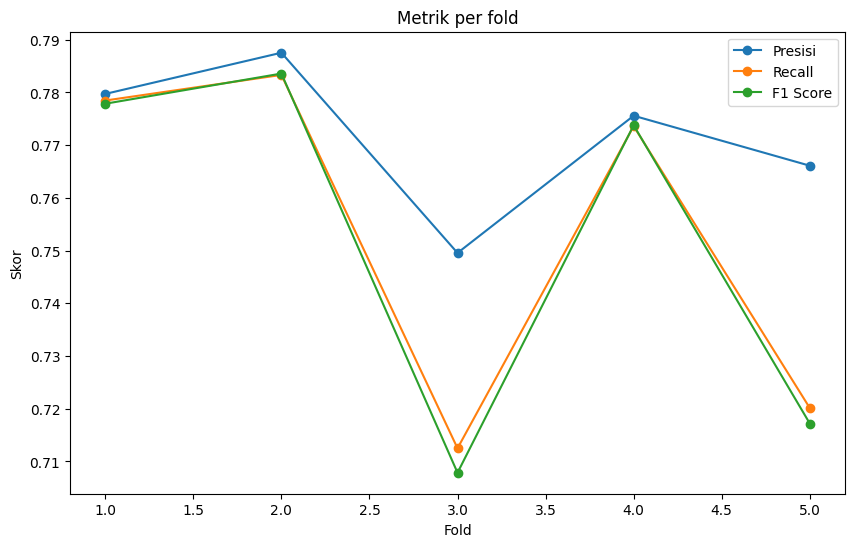

In [17]:
# Jumlah lipatan yang digunakan
n_folds = len(accuracy_per_fold)

# Plot semua metrik dlm satu grafik
plt.figure(figsize=(10, 6))

# Plot presisi
plt.plot(range(1, n_folds + 1), precision_per_fold, marker='o', label='Presisi')

# Plot recall
plt.plot(range(1, n_folds + 1), recall_per_fold, marker='o', label='Recall')

# Plot F1 score
plt.plot(range(1, n_folds + 1), f1_score_per_fold, marker='o', label='F1 Score')

plt.title('Metrik per fold')
plt.xlabel('Fold')
plt.ylabel('Skor')
plt.legend()
plt.show()

In [18]:
for fold, roc_auc_fold in enumerate(roc_auc_per_fold):
    for i, auc_value in enumerate(roc_auc_fold):
        print(f"ROC AUC untuk fold {fold+1}, Kelas {class_names[i]}: {auc_value}")

ROC AUC untuk fold 1, Kelas AD: 0.8898148148148147
ROC AUC untuk fold 1, Kelas CN: 0.8504629629629629
ROC AUC untuk fold 1, Kelas EMCI: 0.8388888888888888
ROC AUC untuk fold 1, Kelas LMCI: 0.8300925925925927
ROC AUC untuk fold 2, Kelas AD: 0.8712962962962962
ROC AUC untuk fold 2, Kelas CN: 0.8597222222222222
ROC AUC untuk fold 2, Kelas EMCI: 0.8541666666666666
ROC AUC untuk fold 2, Kelas LMCI: 0.837037037037037
ROC AUC untuk fold 3, Kelas AD: 0.8453703703703703
ROC AUC untuk fold 3, Kelas CN: 0.7324074074074075
ROC AUC untuk fold 3, Kelas EMCI: 0.8523148148148147
ROC AUC untuk fold 3, Kelas LMCI: 0.8032407407407408
ROC AUC untuk fold 4, Kelas AD: 0.8726851851851852
ROC AUC untuk fold 4, Kelas CN: 0.8240740740740742
ROC AUC untuk fold 4, Kelas EMCI: 0.8504629629629629
ROC AUC untuk fold 4, Kelas LMCI: 0.8490740740740741
ROC AUC untuk fold 5, Kelas AD: 0.8305555555555555
ROC AUC untuk fold 5, Kelas CN: 0.824074074074074
ROC AUC untuk fold 5, Kelas EMCI: 0.8564814814814814
ROC AUC untuk f

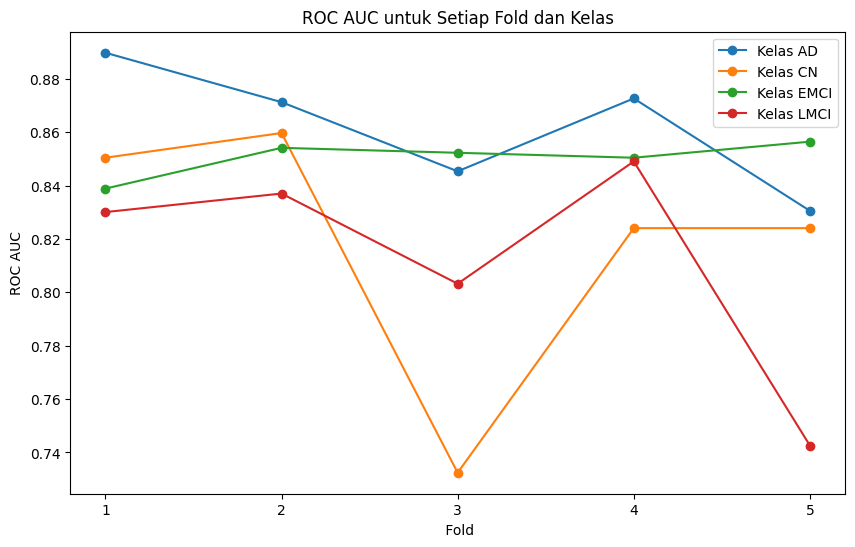

In [19]:
n_folds = len(roc_auc_per_fold)
n_classes = len(class_names)

# Data untuk plotting
data = np.array(roc_auc_per_fold)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Membuat garis untuk setiap kelas
for i in range(n_classes):
    ax.plot(range(1, n_folds + 1), data[:, i], marker='o', label=f'Kelas {class_names[i]}')

ax.set_xlabel(' Fold')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC untuk Setiap Fold dan Kelas')
ax.set_xticks(range(1, n_folds + 1)) 
ax.legend()

plt.show()

In [20]:
# Cetak average ROC AUC
average_roc_auc = np.mean(roc_auc_per_fold)
print(f'Average ROC AUC: {average_roc_auc:.2f}')

Average ROC AUC: 0.84
